In [1]:
from scimath.units.length import meters as m
from scimath.units.length import kilometers as km
from scimath.units.length import light_year as ly
from scimath.units.mass import kilograms as kg
from scimath.units.time import seconds as s
from scimath.units.time import years as yr
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
G = 6.674e-11 * m**3 / kg / s**2
c = 299792458 * m / s
solar_mass = 1.98847e30 * kg
g = 9.81 * m / (s**2)

In [3]:
def v_escape_solar(departure_distance):
    v = (2 * G * solar_mass / departure_distance)**0.5
    return v

In [96]:
class Starship:
    """A Starship that burns fuel to accelerate.
    
    This assumes constant accelerations and nonrelativistic speeds.
    """
    def __init__(self,
                 payload_mass,
                 fuel_mass,
                 initial_velocity = 0 * m / s,
                 initial_position = 0 * km,
                 initial_time = 0 * s,
                 exhaust_velocity = 500 * km / s,
                 destination_distance = 4.244 * ly
                 ):
        self.payload_mass = payload_mass
        self.fuel_mass = fuel_mass
        self.velocity = initial_velocity
        self.position = initial_position
        self.time = initial_time
        self.exhaust_velocity = exhaust_velocity
        self.destination_distance = destination_distance
        self.history = list()
        self.log_messages = list()
        self.log_entry()
        
        
    def log_entry(self, message: str = ''):
        new_log = {'time': self.time,
                   'position': self.position,
                   'velocity': self.velocity,
                   'fuel_mass': self.fuel_mass}
        self.history.append(new_log)
        self.log_messages.append(message)
        
    def total_mass(self):
        return self.payload_mass + self.fuel_mass
        
    def accelerate(self,
                   target_velocity = 0 * km / s, 
                   fuel_mass = None,
                   decelerate = False,
                   acceleration = g):
        """Accelerate the ship by burning a specified quantity of fuel.
        
        If no fuel mass is specified, a target_velocity should be specified instead.
        
        Args:
            target_velocity: unit (speed)
                Target velocity to accelerate to.
            fuel_mass: unit (mass)
                Amount of fuel mass to burn
            decelerate: bool
                If True, acceleration is toward the origin. If False, acceleration is toward the destination
                
        Returns:
            unit (speed)
                New velocity of the starship
        """
        if fuel_mass is not None:
            if fuel_mass / kg > self.fuel_mass / kg:
                raise ValueError(f"Not enough fuel for this maneuver. Requested {fuel_mass} of {self.fuel_mass}.")
            delta_v = self.exhaust_velocity * np.log(self.total_mass() / (self.total_mass() - fuel_mass))
            delta_t = np.abs(delta_v) / g
            self.time += delta_t
            if decelerate:
                delta_pos = self.velocity * delta_t - 0.5 * acceleration * delta_t ** 2
                self.velocity -= delta_v
            else:
                delta_pos = self.velocity * delta_t + 0.5 * acceleration * delta_t ** 2
                self.velocity += delta_v
            self.time += np.abs(delta_v) / g
            self.position += delta_pos
            self.fuel_mass -= fuel_mass
            
        
        else:
            final_mass = self.total_mass() * np.exp(-1 * np.abs(self.velocity - target_velocity) / self.exhaust_velocity)
            delta_fuel_mass = self.total_mass() - final_mass
            self.fuel_mass -= delta_fuel_mass
            if self.fuel_mass / kg < 0:
                raise ValueError(f"Note enough fuel for this maneuver. Requested {delta_fuel_mass} of {self.fuel_mass + delta_fuel_mass}.")
            
            delta_v = target_velocity - self.velocity
            delta_t = np.abs(delta_v) / g
            if decelerate:
                delta_pos = self.velocity * delta_t - 0.5 * acceleration * delta_t ** 2
            else:
                delta_pos = self.velocity * delta_t + 0.5 * acceleration * delta_t ** 2
            self.time += delta_t
            self.velocity = target_velocity
            self.position += delta_pos
            
        if abs(self.velocity / c) > 0.5:
            raise NotImplementedError("This ship is travelling at reletivistic speeds. This is not currently supported.")
            
        self.log_entry(
            f"year {(self.time - delta_t) / yr:0.1f} - Acceleration: {acceleration / g:0.1f} g for {delta_t / yr:0.2e} years. "
            f" New velocity is {self.velocity / c:0.2e} c. "
            f" {self.fuel_mass / kg:0.2e} kg of fuel remaining."
        )
            
        return self.velocity
    
    def cruise(self, distance):
        if self.velocity == 0:
            raise ValueError(f"The starship is not moving. Can't cruise.")
        delta_pos = distance * np.sign(self.velocity / (m / s))
        delta_t = np.abs(distance / self.velocity)
        self.position += delta_pos
        self.time += delta_t
        self.log_entry(
            f"year {(self.time - delta_t) / yr:0.1f} - Cruise: {delta_t / yr:0.2e} years to complete. "
            f"Distance={distance / ly:0.2e} lightyears")
        
    def wait(self, time):
        self.time += time
        distance = self.velocity * time
        self.position += distance
        self.log_entry(
            f"year {(self.time - time) / yr:0.1f} - Waited: {time / yr:0.2e} years. "
            f"Distance={distance / ly:0.2e} lightyears")
        
    def print_history(self):
        for log, message in zip(self.history, self.log_messages):
            log = log.copy()
            
            print()
            print(message)
            print(log)
        
    def parse_logs(self):
        positions = []
        velocities = []
        fuels = []
        times = []
        for log in self.history:
            positions.append(log['position'] / ly)
            velocities.append(log['velocity'] / c)
            fuels.append(log['fuel_mass'] / kg)
            times.append(log['time'] / yr)
        return positions, velocities, fuels, times
        
    def plot_history(self):
        positions, velocities, fuels, times = self.parse_logs()
        fig = plt.figure(figsize=(12, 12))
        plt.subplot(311)
        plt.plot(times, velocities)
        plt.xlabel('Time (years)')
        plt.ylabel('Velocity (c)')
        plt.subplot(312)
        plt.plot(times, fuels)
        plt.xlabel('Time (years)')
        plt.ylabel('Fuel Mass (kg)')
        plt.subplot(313)
        plt.plot(times, positions)
        plt.xlabel('Time (years)')
        plt.ylabel('Position (light years)')
        plt.hlines(self.destination_distance / ly, 
                   min(times),
                   max(times),
                   label='Destination',
                   linestyles='dashed')
        plt.legend()
        return fig
        

## Example: Simple Mission

This example mission has a single acceleration phase and a single deceleration phase at the destination

In [97]:
ss = Starship(1.0 * kg, 1000.0 * kg)
ss.wait(10 * yr)
ti = ss.time
ss.accelerate(fuel_mass = 900 * kg)
t_accel = ss.time
ss.cruise(ss.destination_distance)
ss.accelerate(decelerate=True)
ss.wait(10 * yr)
ss.print_history()




{'time': 0.0*s, 'position': 0.0*m, 'velocity': 0.0*m*s**-1, 'fuel_mass': 1000.0*kg}

year 0.0 - Waited: 1.00e+01 years. Distance=0.00e+00 lightyears
{'time': 315576000.0*s, 'position': 0.0*m, 'velocity': 0.0*m*s**-1, 'fuel_mass': 1000.0*kg}

year 10.0 - Acceleration: 1.0 g for 3.70e-03 years.  New velocity is 3.83e-03 c.  1.00e+02 kg of fuel remaining.
{'time': 315809805.7352165*s, 'position': 67033105631.93772*m, 'velocity': 1146817.1312369807*m*s**-1, 'fuel_mass': 100.0*kg}

year 10.0 - Cruise: 1.11e+03 years to complete. Distance=4.24e+00 lightyears
{'time': 35324216034.10684*s, 'position': 4.014830703310563e+16*m, 'velocity': 1146817.1312369807*m*s**-1, 'fuel_mass': 100.0*kg}

year 1119.4 - Acceleration: 1.0 g for 3.70e-03 years.  New velocity is 0.00e+00 c.  9.19e+00 kg of fuel remaining.
{'time': 35324332936.97445*s, 'position': 4.014837406621126e+16*m, 'velocity': 0.0*m*s**-1, 'fuel_mass': 9.19080919080919*kg}

year 1119.4 - Waited: 1.00e+01 years. Distance=0.00e+00 lightyears

/home/mazur/linstore/Software/anaconda3/envs/tf_2.2/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


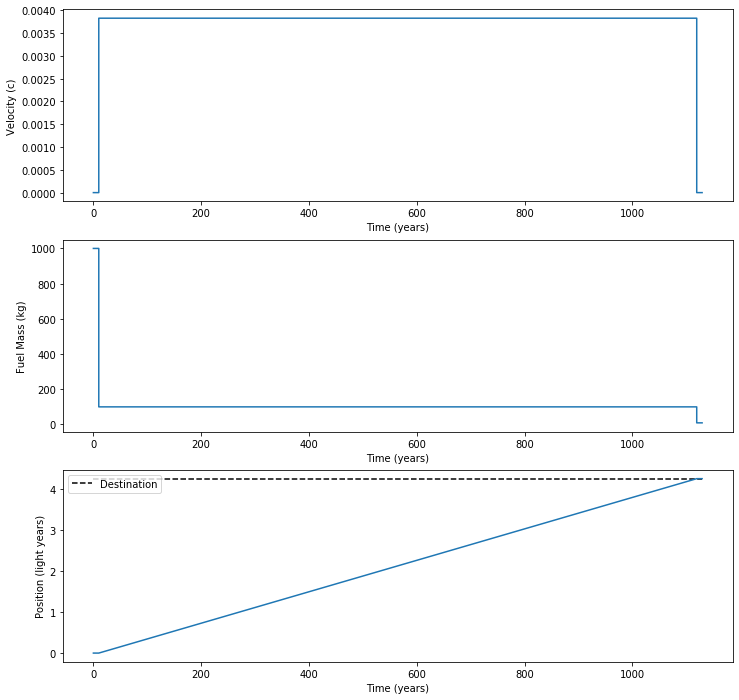

In [98]:
fig = ss.plot_history()
fig.show()

In [99]:
fig.savefig('../images/proxima_centauri.png')

## Example: Aborted mission

In this mission, the crew decides to abort the mission at the half-way point and return to the destination.

In [108]:
ss = Starship(1.0 * kg, 1000.0 * kg)
ss.wait(10 * yr)
ss.accelerate(fuel_mass = 900 * kg)
ss.cruise(ss.destination_distance / 2)
ss.accelerate(decelerate=True)
ss.accelerate(fuel_mass = ss.fuel_mass, decelerate=True)
ss.cruise(ss.destination_distance / 2)
ss.wait(10 * yr)
ss.print_history()



{'time': 0.0*s, 'position': 0.0*m, 'velocity': 0.0*m*s**-1, 'fuel_mass': 1000.0*kg}

year 0.0 - Waited: 1.00e+01 years. Distance=0.00e+00 lightyears
{'time': 315576000.0*s, 'position': 0.0*m, 'velocity': 0.0*m*s**-1, 'fuel_mass': 1000.0*kg}

year 10.0 - Acceleration: 1.0 g for 3.70e-03 years.  New velocity is 3.83e-03 c.  1.00e+02 kg of fuel remaining.
{'time': 315809805.7352165*s, 'position': 67033105631.93772*m, 'velocity': 1146817.1312369807*m*s**-1, 'fuel_mass': 100.0*kg}

year 10.0 - Cruise: 5.55e+02 years to complete. Distance=2.12e+00 lightyears
{'time': 17820012919.921032*s, 'position': 2.007418703310563e+16*m, 'velocity': 1146817.1312369807*m*s**-1, 'fuel_mass': 100.0*kg}

year 564.7 - Acceleration: 1.0 g for 3.70e-03 years.  New velocity is 0.00e+00 c.  9.19e+00 kg of fuel remaining.
{'time': 17820129822.78864*s, 'position': 2.0074254066211264e+16*m, 'velocity': 0.0*m*s**-1, 'fuel_mass': 9.19080919080919*kg}

year 564.7 - Acceleration: 1.0 g for 3.75e-03 years.  New velocit

/home/mazur/linstore/Software/anaconda3/envs/tf_2.2/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


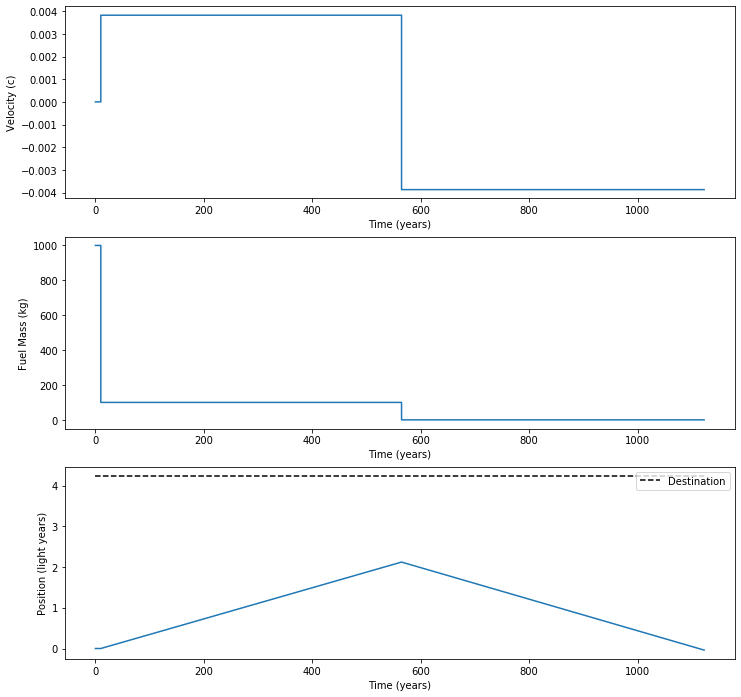

In [109]:
fig = ss.plot_history()
fig.show()

In [111]:
fig.savefig('../images/proxima_centauri_aborted.png')